In [1]:
import numpy as np
import pandas as pd
import pickle
import gc
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
metric_file_names = ['acc_equality_diff.bin', 'acc_equality_ratio.bin', 'disp_impact.bin', 'equal_opp_diff.bin', 'equal_opp_ratio.bin', 
                    'neg_pred_parity_diff.bin', 'neg_pred_parity_ratio.bin', 'pos_pred_parity_diff.bin', 'pred_equality_diff.bin',
                    'pred_equality_ratio.bin', 'pred_parity_ratio.bin', 'stat_parity.bin']
metric_full_names = ['Accuracy equality difference', 'Accuracy equality ratio', 'Disparate impact', 'Equal opportunity difference',
                    'Equal opportunity ratio', 'Negative predictive parity difference', 'Negative predictive parity ratio',
                    'Positive predictive parity difference', 'Predictive equality difference', 'Predictive equality ratio', 
                    'Positive predictive parity ratio', 'Statistical parity']

In [3]:
metric_names = {metric_file_names[idx]: metric_full_names[idx] for idx in range(len(metric_file_names))}

In [4]:
def plot_plot(df, metric):
    fig = (
        ggplot(df, aes(x=metric, fill='typeVal'))
        # ggplot(df, aes(x=metric, y=after_stat('density')))      # to fix: after_stat('density') causes error in scaling
        + geom_histogram(bins=100)
        + scale_color_manual(values = ['red', 'black'])
        + facet_grid('ir~gr', labeller = 'label_both')
        + theme_minimal()
        + theme(figure_size=(16, 8))
        + ggtitle(f"{metric} for selected IR & GR")
        # + ylab("Density")
    )
    print(fig)

### Group ration distribution

In [4]:
with open("gr.bin", "rb") as f:
    gr = pd.DataFrame(np.fromfile(f).astype(np.float16), columns = ["gr"])

array([<AxesSubplot:title={'center':'gr'}>], dtype=object)

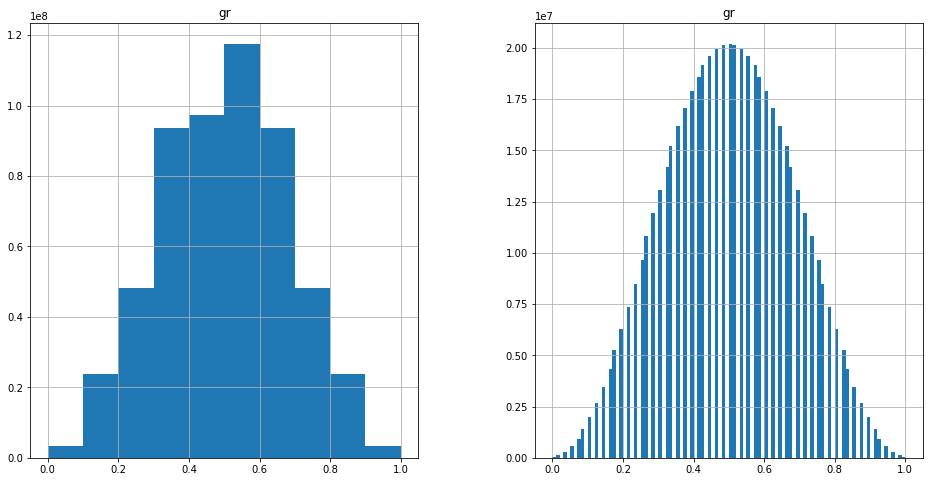

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
gr.hist(ax=ax[0], bins=10)
gr.hist(ax=ax[1], bins=100)

### Imbalance ration distribution

In [4]:
with open("ir.bin", "rb") as f:
    ir = pd.DataFrame(np.fromfile(f).astype(np.float16), columns = ["ir"])

array([<AxesSubplot:title={'center':'ir'}>], dtype=object)

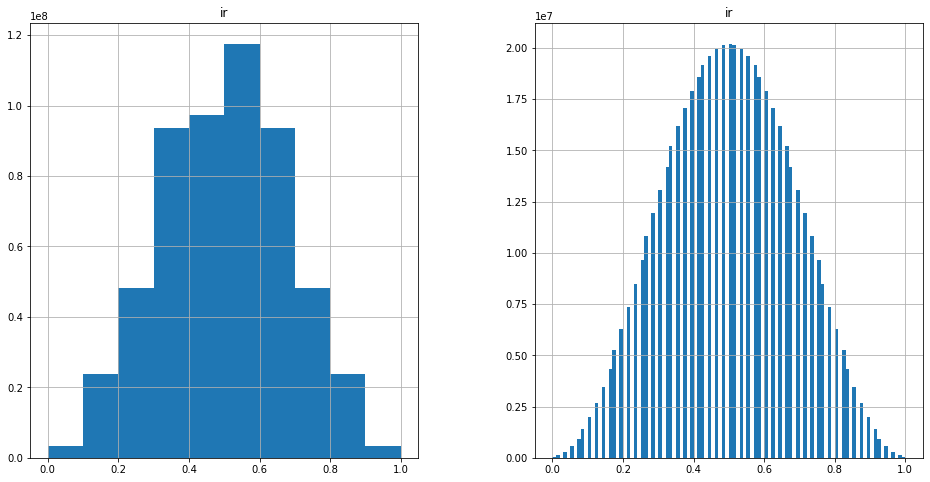

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ir.hist(ax=ax[0], bins=10)
ir.hist(ax=ax[1], bins=100)

In [7]:
ir_selected = [0.25, 0.5, 0.75]
gr_selected = [0.25, 0.5, 0.75]

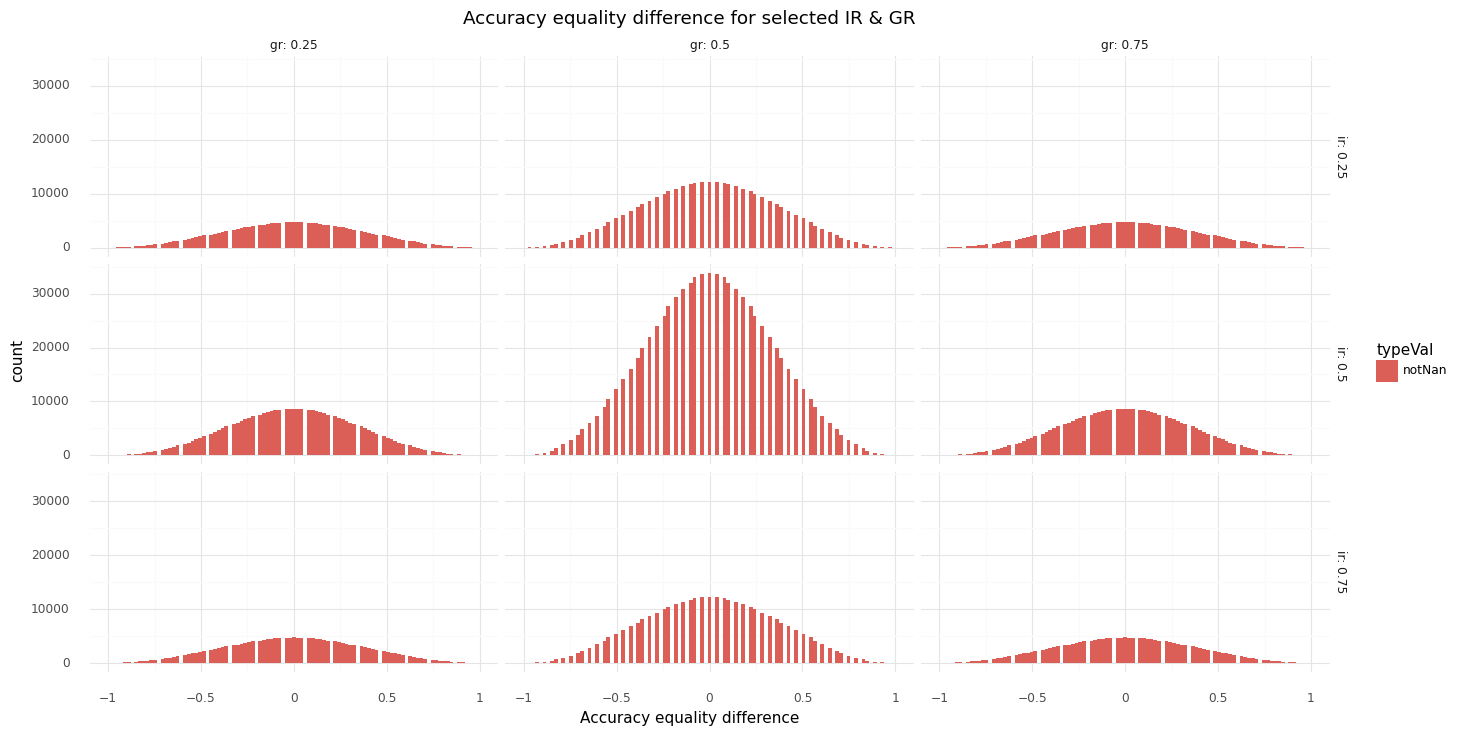

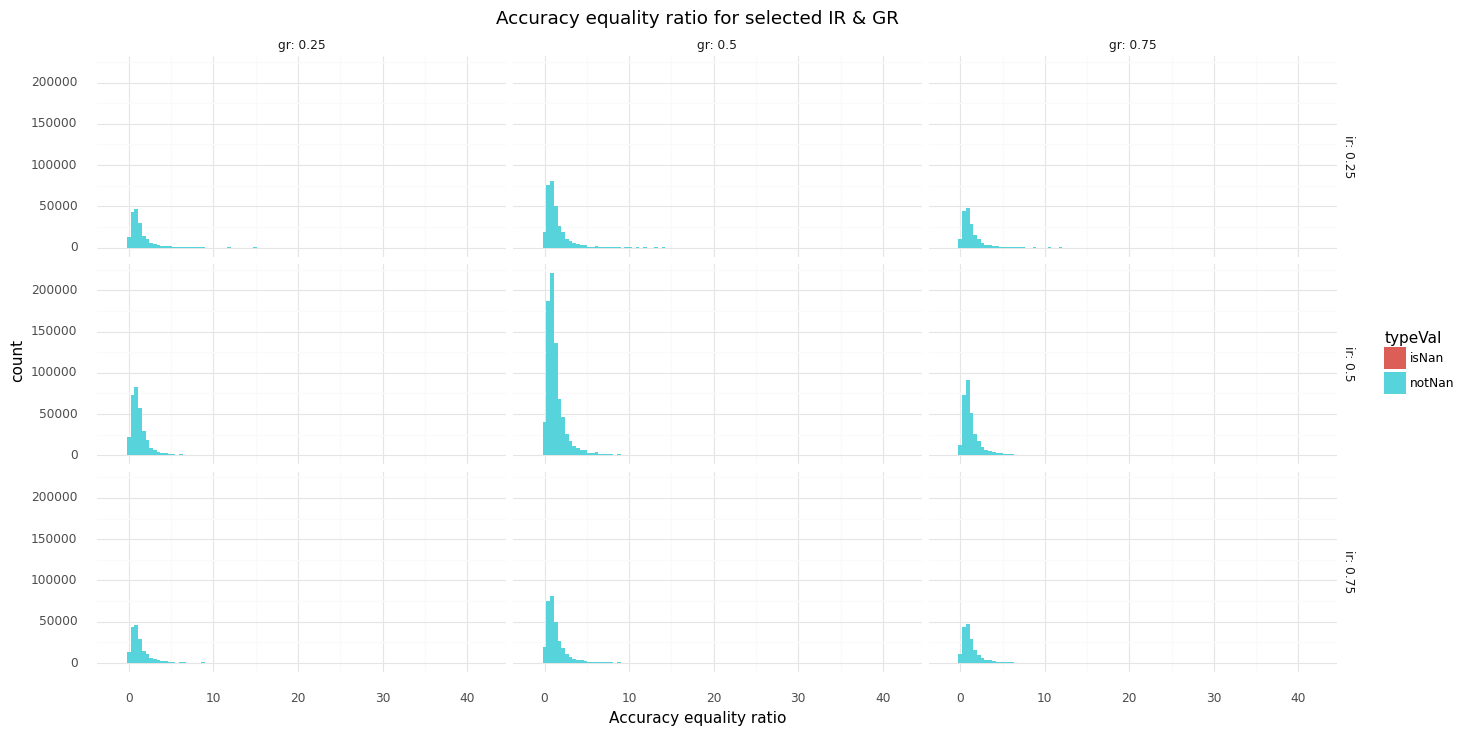

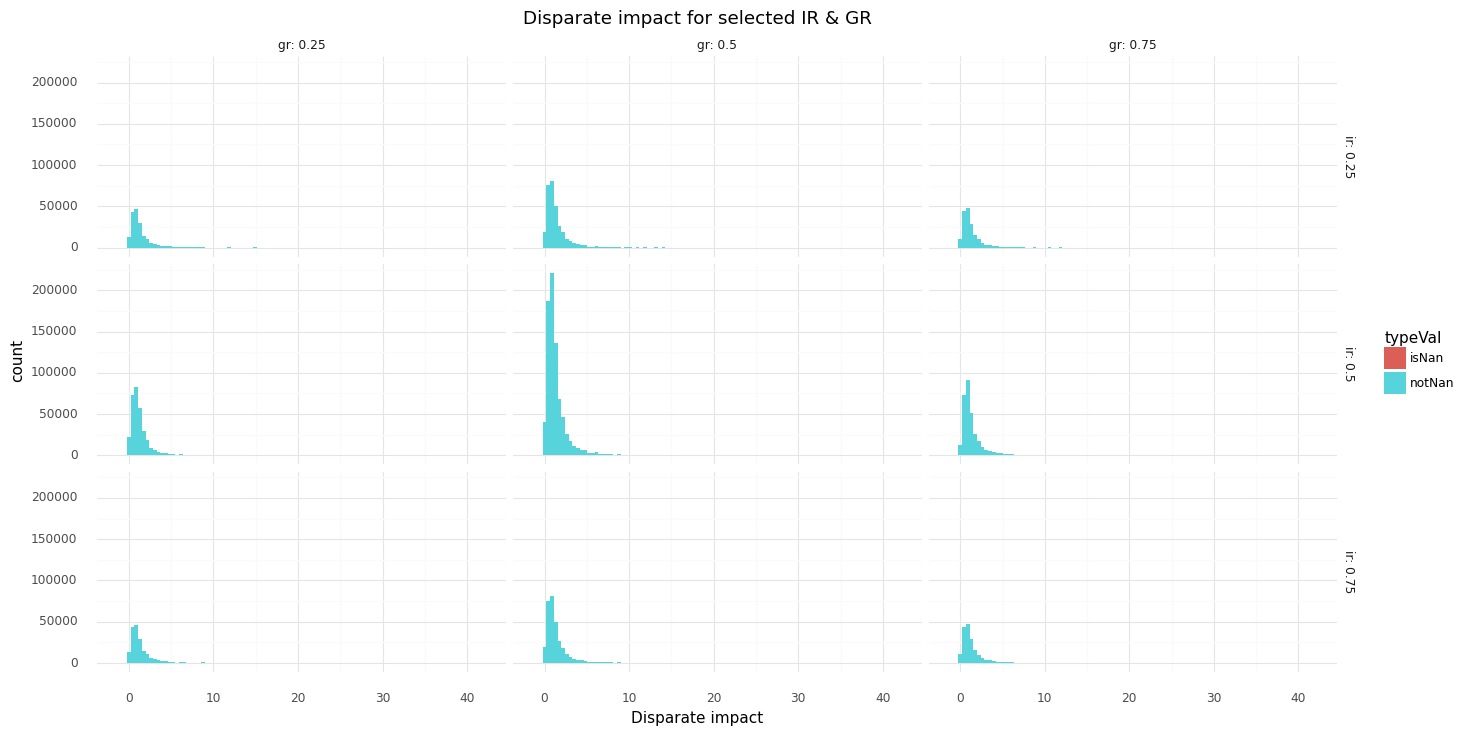

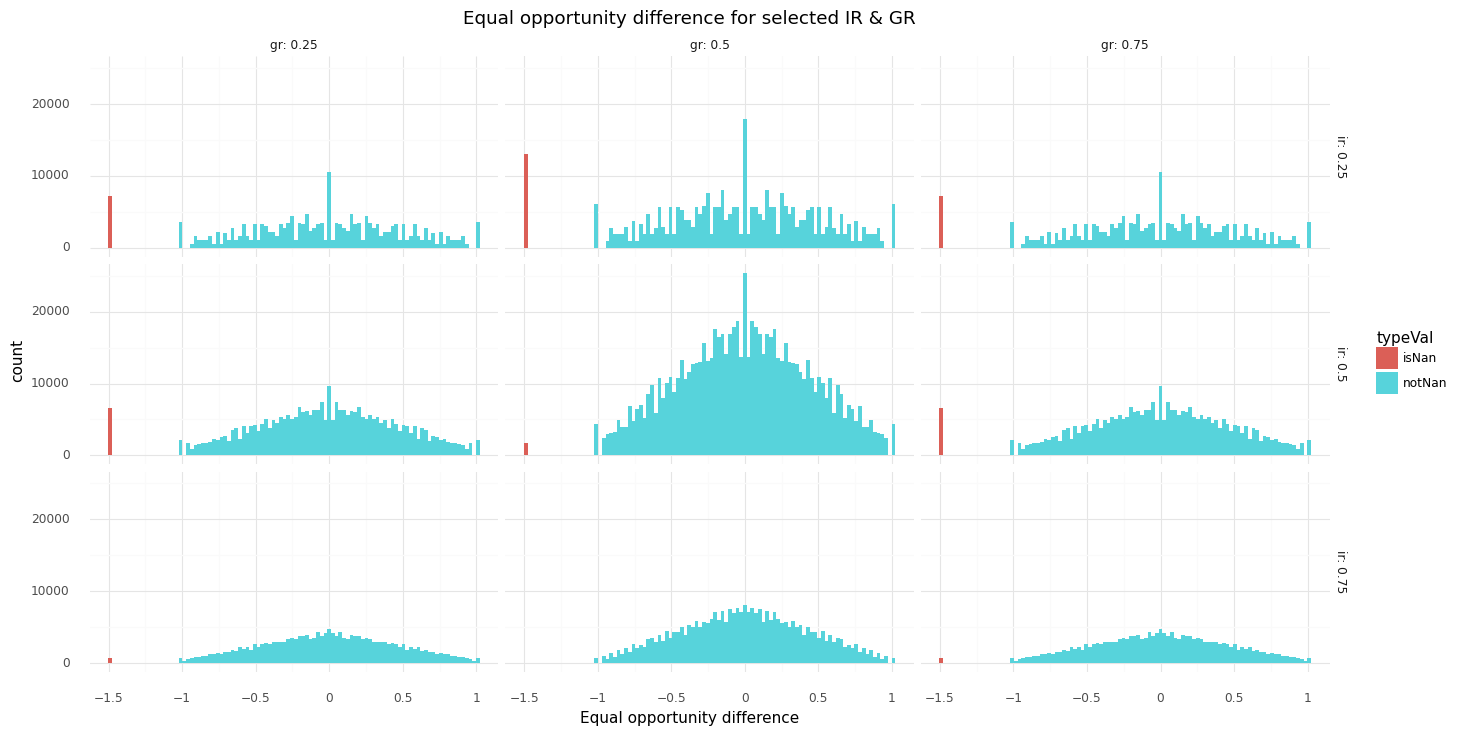

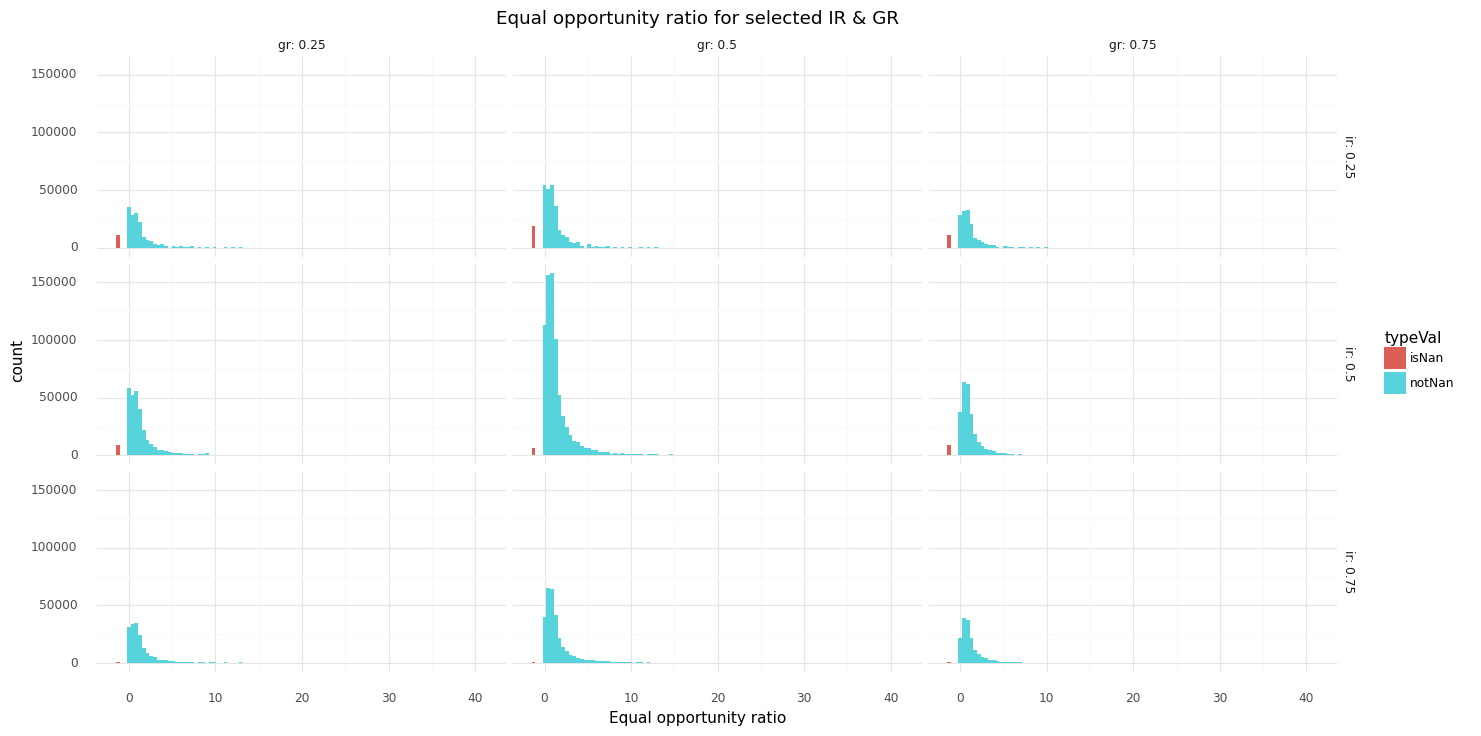

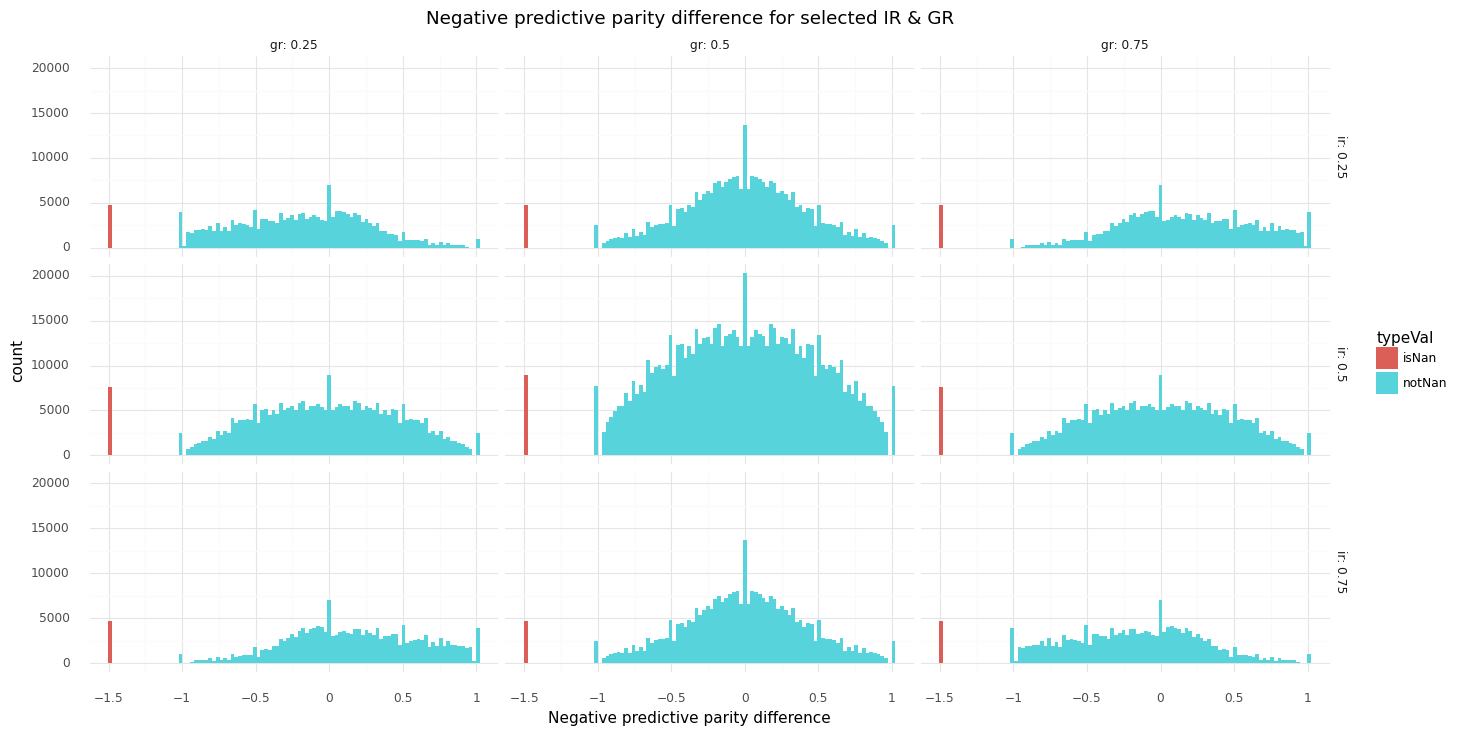

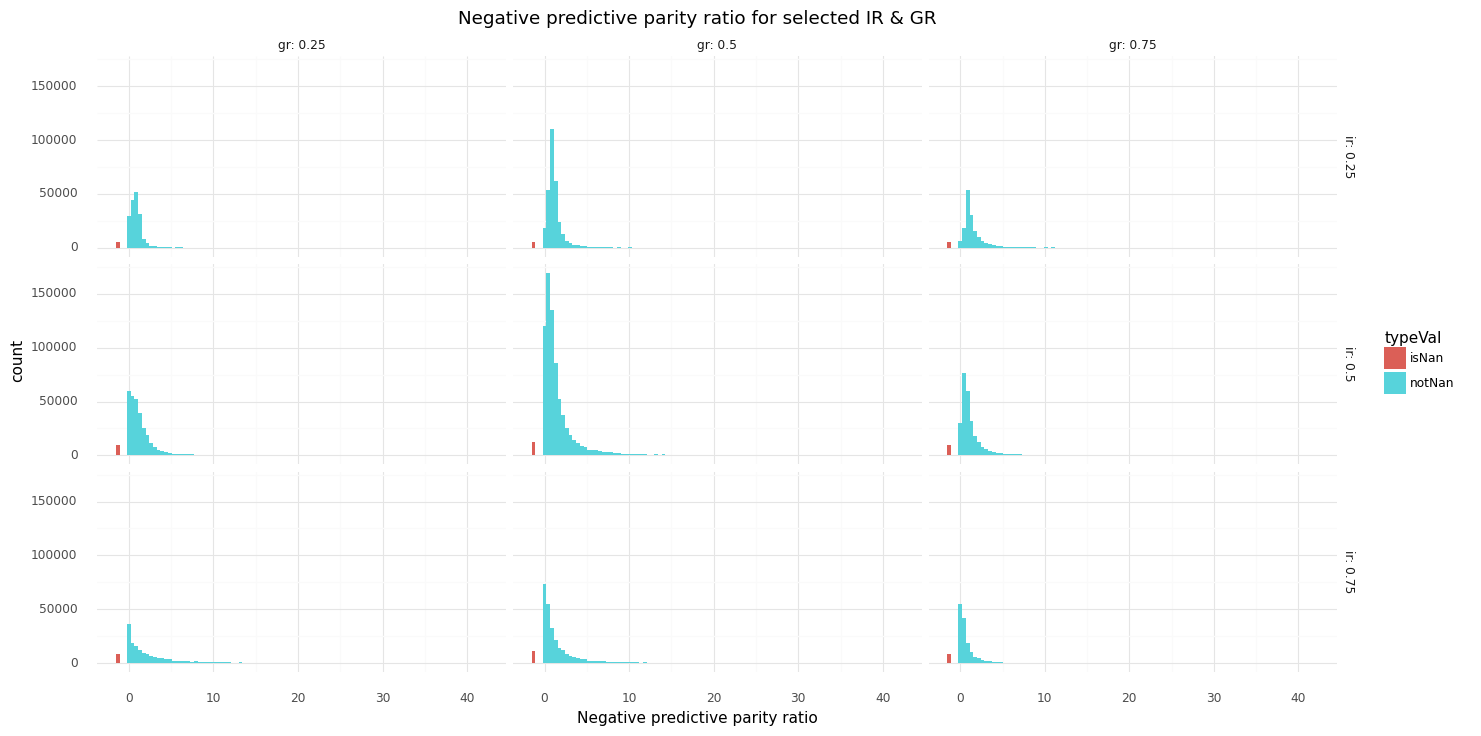

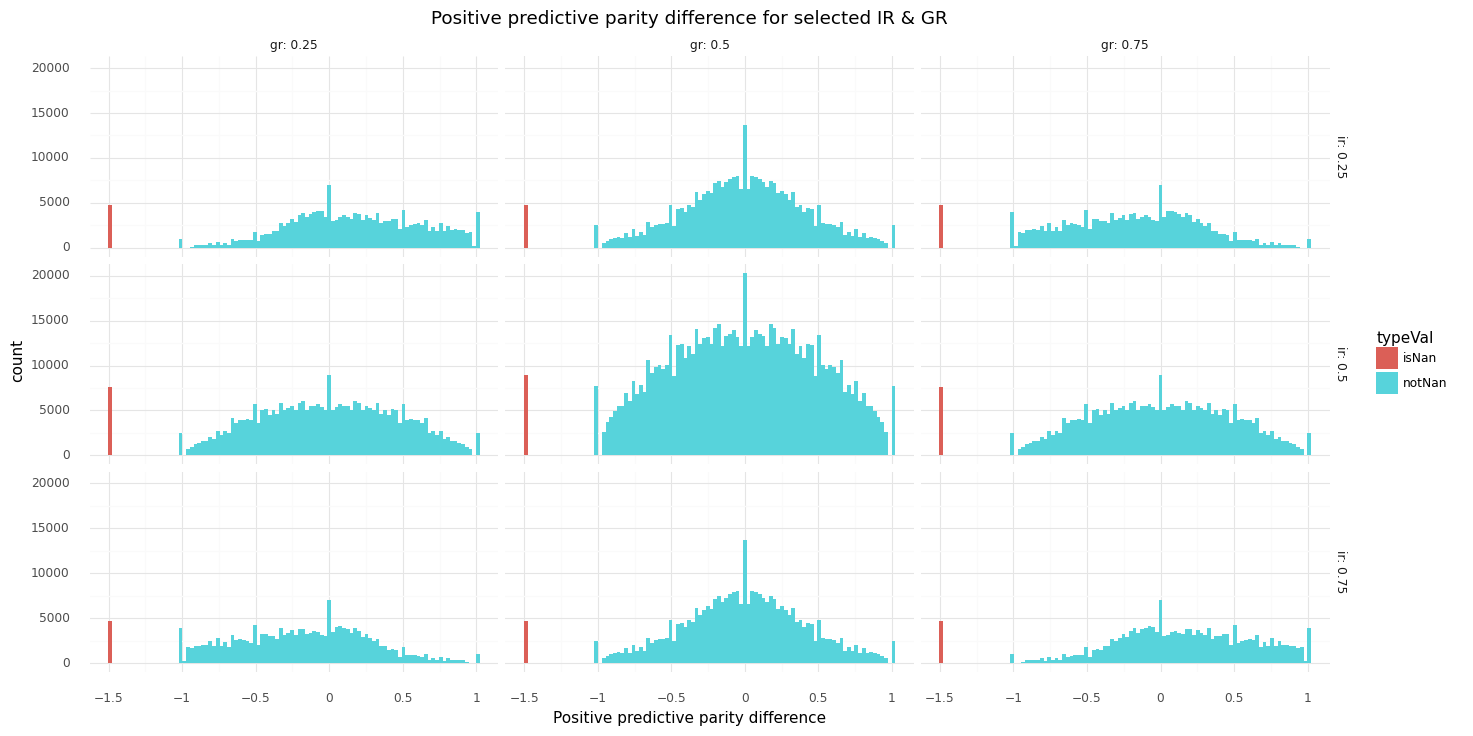

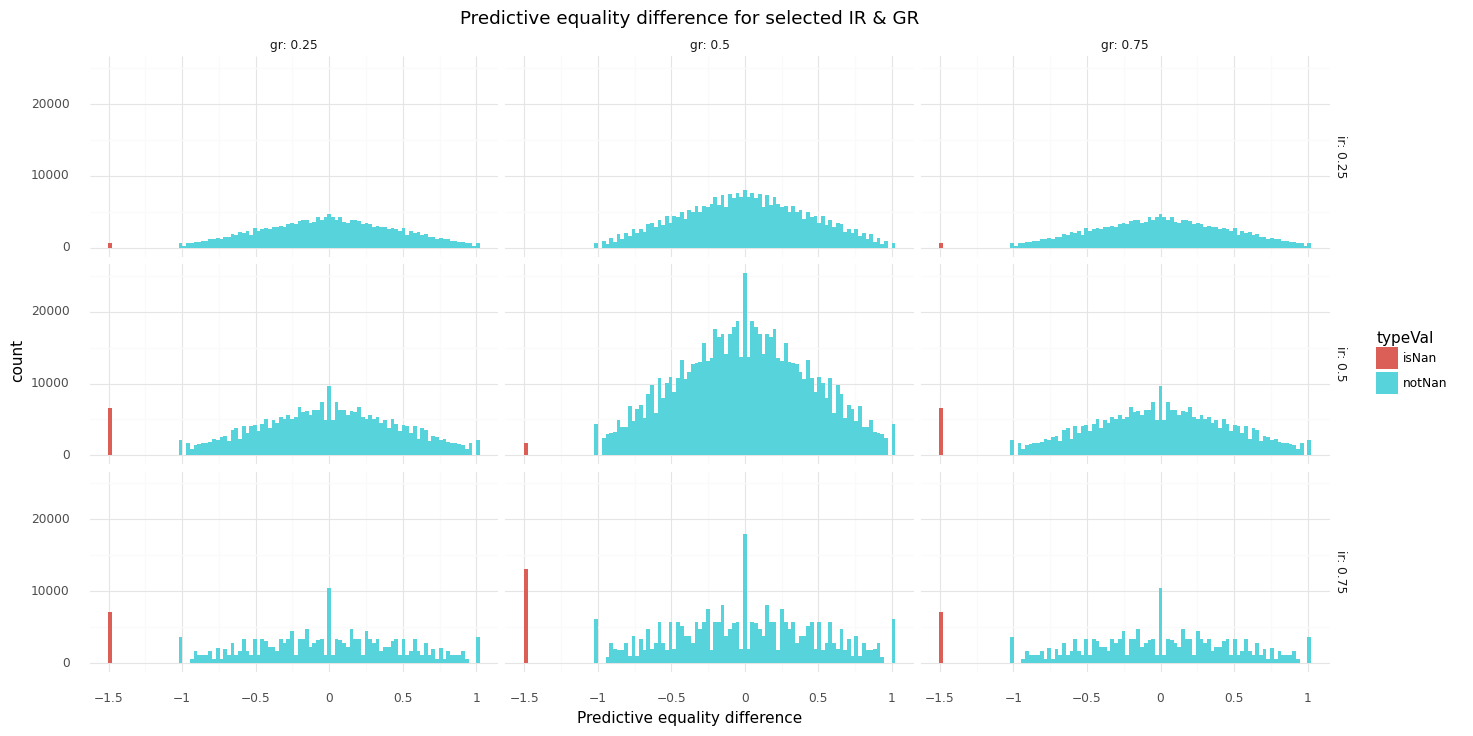

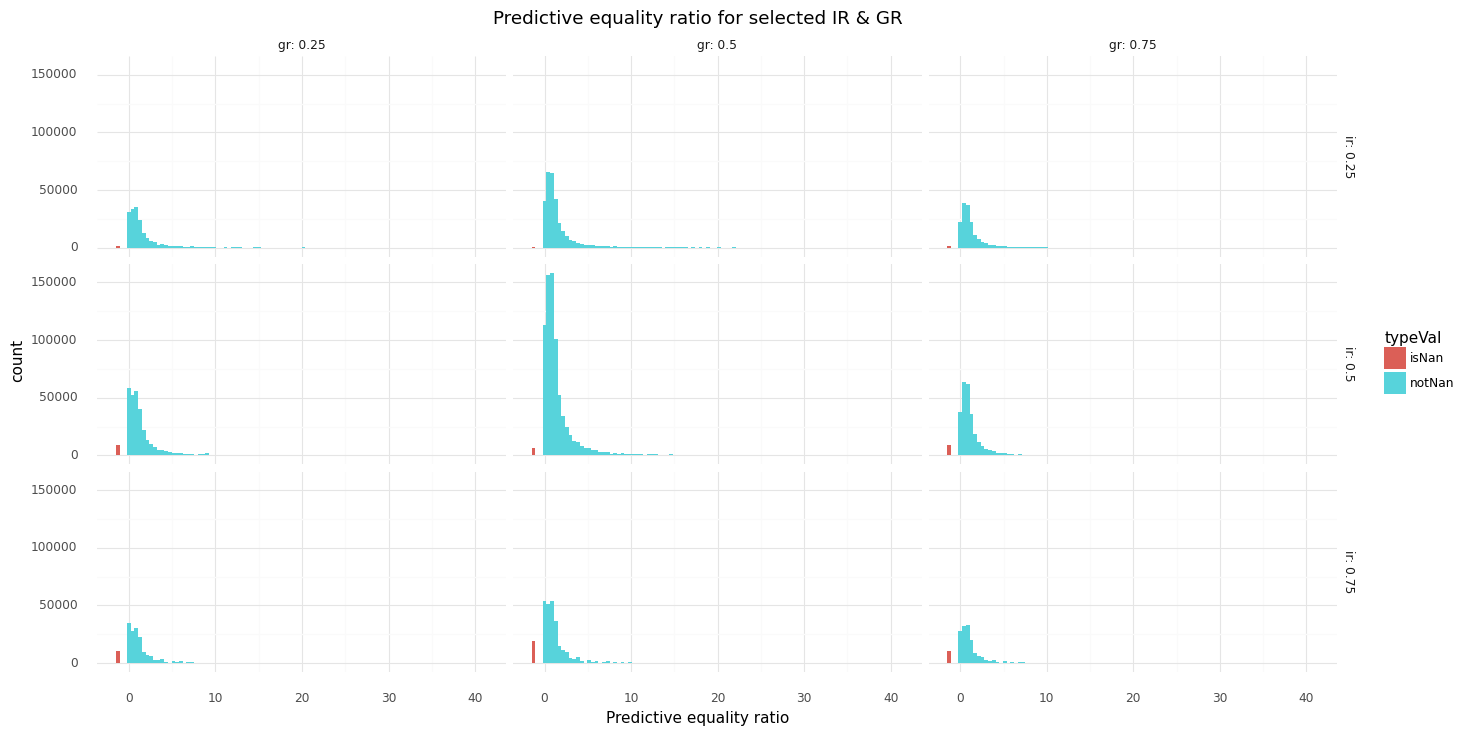

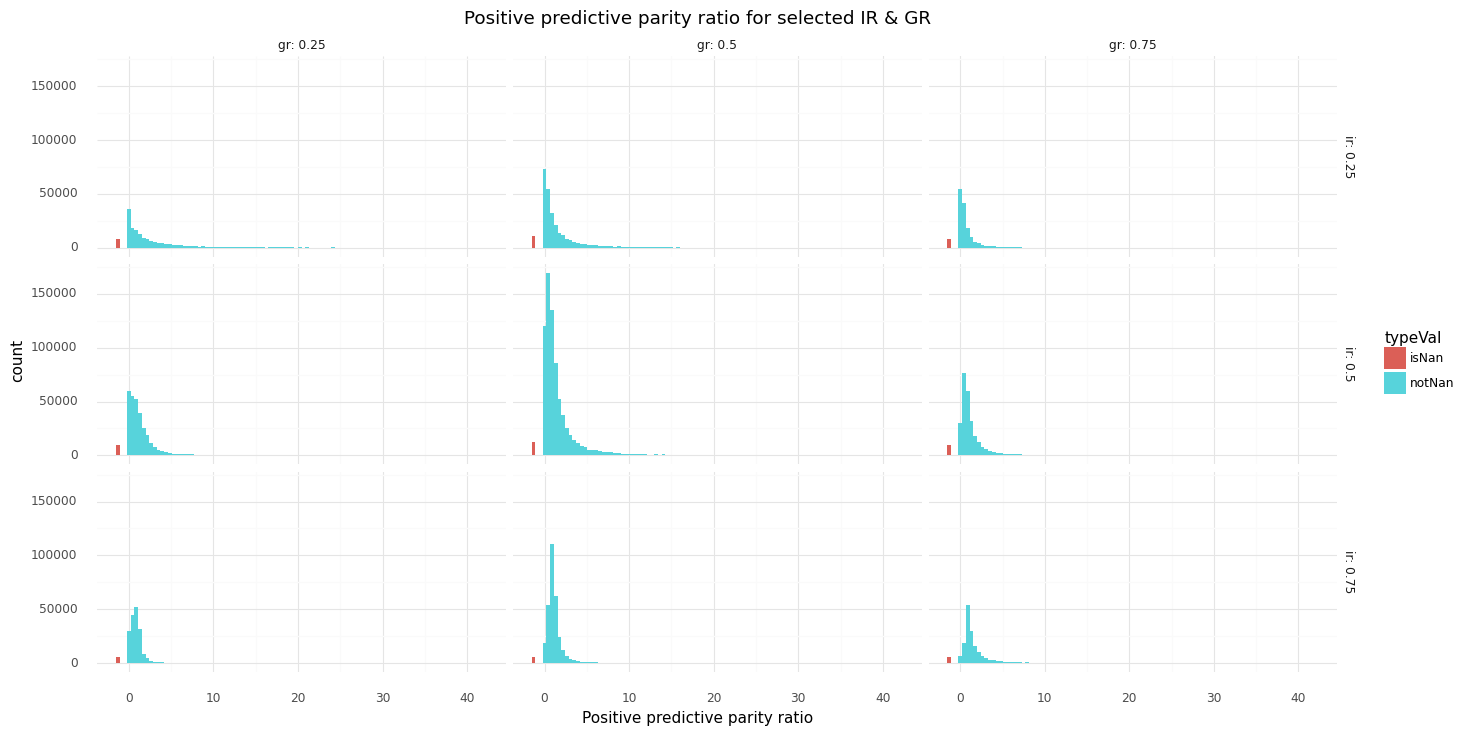

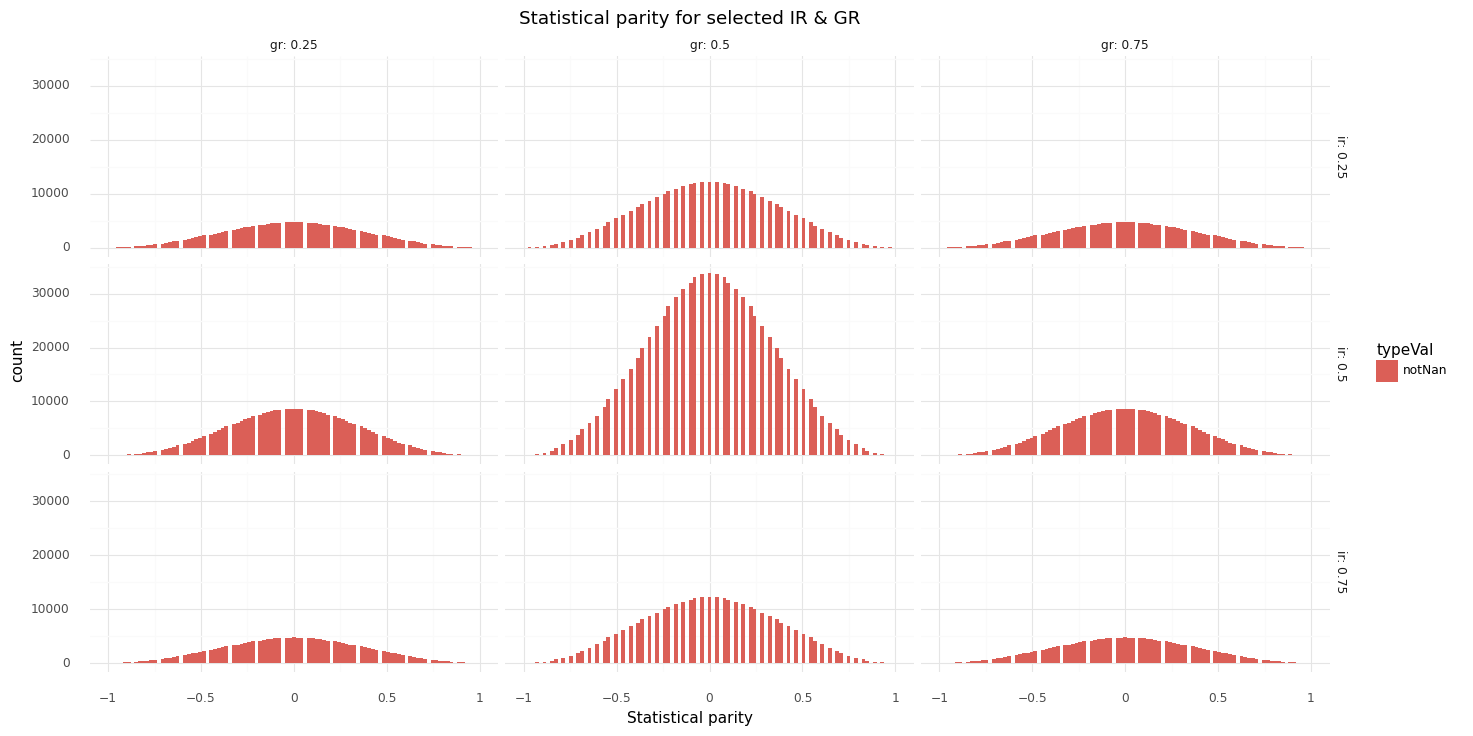

In [8]:
for idx, name in enumerate(metric_file_names):
    col_name = metric_names[name]
    with open(name, "rb") as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns = [col_name])
    df = pd.concat([gr, ir], axis=1)
    df = pd.concat([df, metric], axis=1)
    df = df.loc[df.ir.isin(ir_selected) & df.gr.isin(gr_selected)]
    df.replace(np.nan, -1.5, inplace=True)
    df['typeVal'] = np.where(df[col_name] == -1.5, 'isNan', 'notNan')
    plot_plot(df, col_name)
    del metric
    del df
    gc.collect()
    gc.get_stats()